In [0]:
#Uncomment line below and run if you need to clear all your resources
#!kill -9 -1

In [0]:
#Allows our plots to show up in the notebook

In [12]:
%matplotlib inline

In [13]:
#Import the necessary fastai libraries
from fastai.conv_learner import *
from fastai.plots import *

In [14]:
#Points to our data directory where the training data and labels are located
PATH = 'planet-data/'

In [48]:
from sklearn.metrics import *

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])


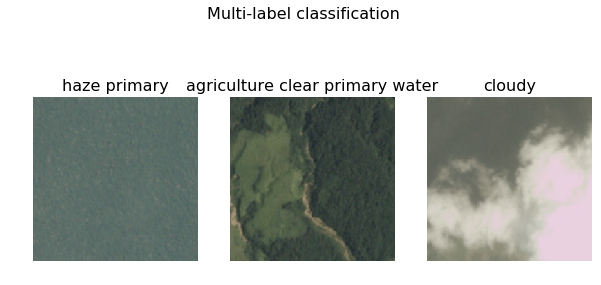

In [49]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg",f"{PATH}train-jpg/train_12.jpg"]
titles=["haze primary", "agriculture clear primary water", "cloudy"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [50]:
#Our pretrained neural net architecture
f_model = resnet34

#The performance measure we will use to evaluate our model
metrics=[f2]

In [51]:
#Point to the file that contains our labels (images -> [list of labels])
label_csv = f'{PATH}train_v2.csv'

#Determine how many images are in the training set (first row is column header)
n = len(list(open(label_csv)))-1

#Identify which images will be part of the validation set (80% train, 20% val)
val_idxs = get_cv_idxs(n)

In [52]:
#Helper method to 
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs)

In [53]:
#This will control how images are scaled before the are passed into the network
sz=64

In [54]:
#Load our data
data = get_data(sz)

In [55]:
#Create a pretrained model from the architecture we specified
learn = ConvLearner.pretrained(f_model, data, metrics=metrics, ps=0.5, precompute=True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [56]:
learn.summary

<bound method ConvLearner.summary of Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.5)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=17, bias=True)
  (7): Sigmoid()
)>

In [57]:
#Define the learning rate
lr = 0.2

In [58]:
#Train for 5 epochs
learn.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss   f2                          
    0      0.150139   0.135001   0.880686  
    1      0.145646   0.130333   0.885799                    
    2      0.141197   0.127491   0.889147                    
    3      0.138396   0.126586   0.88853                     
    4      0.133092   0.125278   0.891747                    



[0.1252779414369929, 0.8917465212734583]

In [59]:
#Define learning rated for different parts of our model
lrs = np.array([lr/9,lr/3,lr])

In [60]:
#Important to turn precompute off so we can now take advantage of data augmentation
learn.precompute=False

#Allow the pretrained network to start learning (weights get updated)
learn.unfreeze()

#Train for 3 epochs (first cycle is of lenght 1 epoch, second cycle is of length 2 epochs)
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.120756   0.10659    0.911082  
    1      0.113517   0.101171   0.915138                    
    2      0.109137   0.098987   0.917239                    



[0.09898691742213292, 0.9172392001410501]

In [61]:
#Test using the validation set and used Test Time Augmentation
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [62]:
#Make final prediction
f2(preds,y)

0.9178938255901196

In [63]:
!rm -r planet-data